# Julius Busecke's AMS 2023 live demo of SST rise

In [ ]:
try:
    client.close()
    cluster.close()
except:
    pass

In [ ]:
import time
tic = time.time()

In [ ]:
cluster_type = 'CodeEngine'
# cluster_type = 'AWSFargate'
# cluster_type = 'Coiled'
# cluster_type = 'Local'

In [ ]:
if cluster_type == 'CodeEngine':
    from dask_cloudprovider.ibm import IBMCodeEngineCluster

    cluster = IBMCodeEngineCluster(
        project_id="xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx",
        image="xxxxxxx/xxxxxxx:latest", 
        n_workers=4,
        scheduler_cpu="4",
        scheduler_mem="16G",
        worker_cpu="4",
        worker_mem="16G",
        region="us-east",
    )

    cluster.adapt(minimum=4, maximum=4)

    client = cluster.get_client()

In [ ]:
if cluster_type == 'AWSFargate':
    from dask_cloudprovider.aws import FargateCluster

    cluster = FargateCluster(
        image="xxxxxxx/xxxxxxx:latest", 
        scheduler_cpu=4096, 
        scheduler_mem=16384,
        worker_cpu=4096,
        worker_mem=16384,
        n_workers=4,
        fargate_spot=True,
        region_name='us-east-2',
    )

    #cluster.adapt(minimum=4, maximum=4)

    client = cluster.get_client()

In [ ]:
if cluster_type == 'Coiled':
    import coiled

    cluster = coiled.Cluster(
        region='us-east',
        name='sst-rise',
        shutdown_on_close=False,
        compute_purchase_option='spot_with_fallback',
        wait_for_workers=True,
        software='sst-rise',
        n_workers=4,
    )

    client = cluster.get_client()

    # Scale the cluster
#    cluster.adapt(minimum=2, maximum=30)

In [ ]:
if cluster_type == 'Local':
    from distributed import Client
    client = Client()

In [ ]:
toc_cluster = time.time()
print(f"Cluster creation time: {toc_cluster - tic} s")

In [8]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from xmip.preprocessing import combined_preprocessing
from xmip.utils import google_cmip_col

from xarrayutils.plotting import shaded_line_plot
xr.set_options(keep_attrs=True)
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.figsize'] = (10,5)

## Load CMIP6 data from Pangeo Cloud Storage

In [9]:
col = google_cmip_col()
query = dict(
    source_id = [
     'IPSL-CM6A-LR',
     'MPI-ESM1-2-LR',
     'GFDL-ESM4',
     'EC-Earth3',
     'CMCC-ESM2',
     'CESM2',
    ],
    experiment_id = ['historical','ssp126', 'ssp370', 'ssp245', 'ssp585'],
    grid_label='gn',
)
cat = col.search(
    **query,
    variable_id='tos',
    member_id=['r1i1p1f1',],#'r2i1p1f1'
    table_id='Omon'
)
kwargs = dict(preprocess=combined_preprocessing, xarray_open_kwargs=dict(use_cftime=True), aggregate=False)
ddict = cat.to_dataset_dict(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [10]:
cat_area = col.search(
    **query,
    table_id='Ofx',
    variable_id='areacello',
)
ddict_area = cat_area.to_dataset_dict(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


## Postprocess loaded data with xmip

In [ ]:
from xmip.postprocessing import match_metrics
ddict_w_area = match_metrics(ddict, ddict_area, 'areacello', print_statistics=True) 

Processed 26 datasets.
Exact matches:{'areacello': 0}
Other matches:{'areacello': 26}
No match found:{'areacello': 0}


In [12]:
from xmip.postprocessing import concat_members

ddict_trimmed = {k:ds.sel(time=slice(None, '2100')) for k,ds in ddict_w_area.items()}
ddict_combined_members = concat_members(
    ddict_w_area,
    concat_kwargs = {'coords':'minimal', 'compat':'override', 'join':'override'}
)

## Organize datasets in xarray-datatree

In [13]:
from datatree import DataTree

# create a path: dataset dictionary, where the path is based on each datasets attributes
tree_dict = {f"{ds.source_id}/{ds.experiment_id}/":ds for ds in ddict_combined_members.values()}

dt = DataTree.from_dict(tree_dict)
dt

DataTree('None', parent=None)
├── DataTree('GFDL-ESM4')
│   ├── DataTree('ssp245')
│   │       Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 1032, y: 576,
│   │                            x: 720, vertex: 4, bnds: 2)
│   │       Coordinates: (12/13)
│   │           lat             (y, x) float32 2MB dask.array<chunksize=(576, 720), meta=np.ndarray>
│   │           lon             (y, x) float32 2MB dask.array<chunksize=(576, 720), meta=np.ndarray>
│   │         * time            (time) object 8kB 2015-01-16 12:00:00 ... 2100-12-16 12:0...
│   │         * x               (x) float64 6kB -299.8 -299.2 -298.8 ... 58.75 59.25 59.75
│   │         * y               (y) float64 5kB -77.91 -77.72 -77.54 ... 89.47 89.68 89.89
│   │           lat_verticies   (y, x, vertex) float32 7MB dask.array<chunksize=(576, 720, 4), meta=np.ndarray>
│   │           ...              ...
│   │           time_bounds     (time, bnds) object 17kB dask.array<chunksize=(1032, 2), meta=np.ndarray>
│   │           lon_bounds      (bnds, y, x) float32 3MB dask.array<chunksize=(1, 576, 720), meta=np.ndarray>
│   │           lat_bounds      (bnds, y, x) float32 3MB dask.array<chunksize=(1, 576, 720), meta=np.ndarray>
│   │         * member_id       (member_id) object 8B 'r1i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 8B nan
│   │           areacello       (member_id, dcpp_init_year, y, x) float32 2MB dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
│   │       Dimensions without coordinates: vertex, bnds
│   │       Data variables:
│   │           tos             (member_id, dcpp_init_year, time, y, x) float32 2GB dask.array<chunksize=(1, 1, 64, 576, 720), meta=np.ndarray>
│   │       Attributes: (12/62)
│   │           Conventions:                      CF-1.7 CMIP-6.0 UGRID-1.0
│   │           activity_id:                      ScenarioMIP
│   │           branch_method:                    standard
│   │           branch_time_in_child:             60225.0
│   │           branch_time_in_parent:            60225.0
│   │           comment:                          <null ref>
│   │           ...                               ...
│   │           intake_esm_attrs:variable_id:     tos
│   │           intake_esm_attrs:grid_label:      gn
│   │           intake_esm_attrs:zstore:          gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/...
│   │           intake_esm_attrs:version:         20180701
│   │           intake_esm_attrs:_data_format_:   zarr
│   │           intake_esm_dataset_key:           ScenarioMIP.NOAA-GFDL.GFDL-ESM4.ssp245....
│   ├── DataTree('ssp370')
│   │       Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 1032, y: 576,
│   │                            x: 720, vertex: 4, bnds: 2)
│   │       Coordinates: (12/13)
│   │           lat             (y, x) float32 2MB dask.array<chunksize=(576, 720), meta=np.ndarray>
│   │           lon             (y, x) float32 2MB dask.array<chunksize=(576, 720), meta=np.ndarray>
│   │         * time            (time) object 8kB 2015-01-16 12:00:00 ... 2100-12-16 12:0...
│   │         * x               (x) float64 6kB -299.8 -299.2 -298.8 ... 58.75 59.25 59.75
│   │         * y               (y) float64 5kB -77.91 -77.72 -77.54 ... 89.47 89.68 89.89
│   │           lat_verticies   (y, x, vertex) float32 7MB dask.array<chunksize=(576, 720, 4), meta=np.ndarray>
│   │           ...              ...
│   │           time_bounds     (time, bnds) object 17kB dask.array<chunksize=(1032, 2), meta=np.ndarray>
│   │           lon_bounds      (bnds, y, x) float32 3MB dask.array<chunksize=(1, 576, 720), meta=np.ndarray>
│   │           lat_bounds      (bnds, y, x) float32 3MB dask.array<chunksize=(1, 576, 720), meta=np.ndarray>
│   │         * member_id       (member_id) object 8B 'r1i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 8B nan
│   │           areacello       (member_id, dcpp_init_year, y, x) float32 2MB dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
│   

In [14]:
dt.nbytes / 1e9  # size in GB

20.910565072

## Select a single member that is present in each experiment

In [15]:
dt_single_member = DataTree()
for model_name, model in dt.children.items():
    member_id_values = []
    for experiment_name, experiment in model.children.items():
        ds = experiment.ds
        member_id_values.append(set(ds.member_id.data))  
    
    # find the intersection of all values
    # print(member_id_values)
    full_members = set(member_id_values[0]).intersection(*member_id_values)
    # sort and take the first one
    pick_member = sorted(full_members)[0]
    dt_single_member[model_name] = model.sel(member_id=pick_member)

## Compute weighted global mean SST

In [16]:
# average temperature globally
def global_mean_sst(ds):
    return ds.tos.weighted(ds.areacello.fillna(0)).mean(['x', 'y']).persist() 

timeseries = dt_single_member.map_over_subtree(global_mean_sst)
timeseries

DataTree('None', parent=None)
├── DataTree('GFDL-ESM4')
│   ├── DataTree('ssp245')
│   │       Dimensions:         (time: 1032, dcpp_init_year: 1)
│   │       Coordinates:
│   │         * time            (time) object 8kB 2015-01-16 12:00:00 ... 2100-12-16 12:0...
│   │           member_id       <U8 32B 'r1i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 8B nan
│   │       Data variables:
│   │           tos             (dcpp_init_year, time) float32 4kB dask.array<chunksize=(1, 64), meta=np.ndarray>
│   ├── DataTree('ssp370')
│   │       Dimensions:         (time: 1032, dcpp_init_year: 1)
│   │       Coordinates:
│   │         * time            (time) object 8kB 2015-01-16 12:00:00 ... 2100-12-16 12:0...
│   │           member_id       <U8 32B 'r1i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 8B nan
│   │       Data variables:
│   │           tos             (dcpp_init_year, time) float32 4kB dask.array<chunksize=(1, 128), meta=np.ndarray>
│   ├── DataTree('ssp585')
│   │       Dimensions:         (time: 1032, dcpp_init_year: 1)
│   │       Coordinates:
│   │         * time            (time) object 8kB 2015-01-16 12:00:00 ... 2100-12-16 12:0...
│   │           member_id       <U8 32B 'r1i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 8B nan
│   │       Data variables:
│   │           tos             (dcpp_init_year, time) float32 4kB dask.array<chunksize=(1, 64), meta=np.ndarray>
│   ├── DataTree('historical')
│   │       Dimensions:         (time: 1980, dcpp_init_year: 1)
│   │       Coordinates:
│   │         * time            (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:...
│   │           member_id       <U8 32B 'r1i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 8B nan
│   │       Data variables:
│   │           tos             (dcpp_init_year, time) float32 8kB dask.array<chunksize=(1, 120), meta=np.ndarray>
│   └── DataTree('ssp126')
│           Dimensions:         (time: 1032, dcpp_init_year: 1)
│           Coordinates:
│             * time            (time) object 8kB 2015-01-16 12:00:00 ... 2100-12-16 12:0...
│               member_id       <U8 32B 'r1i1p1f1'
│             * dcpp_init_year  (dcpp_init_year) float64 8B nan
│           Data variables:
│               tos             (dcpp_init_year, time) float32 4kB dask.array<chunksize=(1, 64), meta=np.ndarray>
├── DataTree('MPI-ESM1-2-LR')
│   ├── DataTree('historical')
│   │       Dimensions:         (time: 1980, dcpp_init_year: 1)
│   │       Coordinates:
│   │         * time            (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:...
│   │           member_id       <U8 32B 'r1i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 8B nan
│   │       Data variables:
│   │           tos             (dcpp_init_year, time) float32 8kB dask.array<chunksize=(1, 397), meta=np.ndarray>
│   ├── DataTree('ssp370')
│   │       Dimensions:         (time: 1032, dcpp_init_year: 1)
│   │       Coordinates:
│   │         * time            (time) object 8kB 2015-01-16 12:00:00 ... 2100-12-16 12:0...
│   │           member_id       <U8 32B 'r1i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 8B nan
│   │       Data variables:
│   │           tos             (dcpp_init_year, time) float32 4kB dask.array<chunksize=(1, 394), meta=np.ndarray>
│   ├── DataTree('ssp126')
│   │       Dimensions:         (time: 1032, dcpp_init_year: 1)
│   │       Coordinates:
│   │         * time            (time) object 8kB 2015-01-16 12:00:00 ... 2100-12-16 12:0...
│   │           member_id       <U8 32B 'r1i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 8B nan
│   │       Data variables:
│   │           tos             (dcpp_init_year, time) float32 4kB dask.array<chunksize=(1, 394), meta=np.ndarray>
│   ├── DataTree('ssp245')
│   │       Dimensions:         (time: 1032, dcpp_init_year: 1)
│   │       Coordinates:
│   │         * time            (time) object 8kB 2015-01

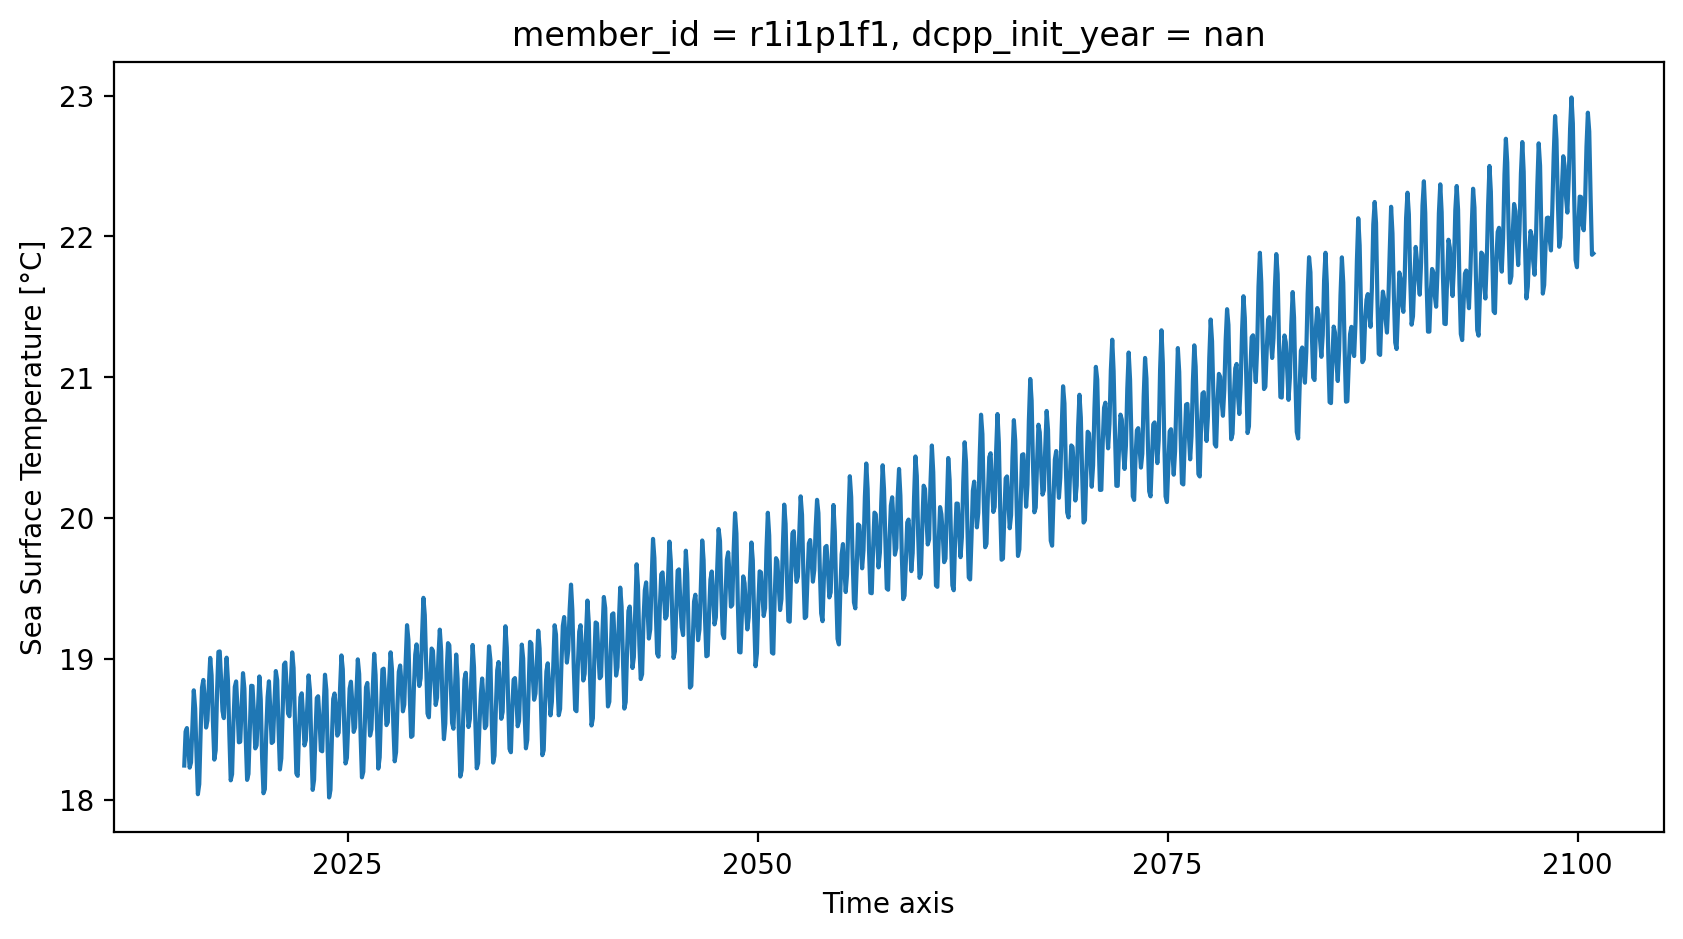

In [17]:
timeseries['/IPSL-CM6A-LR/ssp585'].ds['tos'].plot()

## Compute anomaly to 1950-1980

In [18]:
def get_ref_value(ds):
    return ds.sel(time=slice('1950','1980')).mean('time')

anomaly = DataTree()
for model_name, model in timeseries.children.items():
    # model-specific base period
    base_period = get_ref_value(model["historical"].ds)
    anomaly[model_name] = model - base_period   # subtree - Dataset

In [19]:
%%time
def replace_time(ds):
    start_date = ds.time.data[0]
    new_time = xr.cftime_range(f"{start_date.year}-{start_date.month:02}", freq='1MS', periods=len(ds.time))
    ds_new_cal = ds.assign_coords(time=new_time, source_id=model_name)
    return ds_new_cal
    

experiment_dict = {k:[] for k in ['historical','ssp126', 'ssp370', 'ssp245', 'ssp585']}

for model_name, model in anomaly.children.items():
    for experiment_name, experiment in model.children.items():
        # replace the time dimension
        ds_new_cal = replace_time(experiment.ds)
        experiment_dict[experiment_name].append(ds_new_cal.load())

# concatenate all models for a given experiment
plot_dict = {k:xr.concat(ds_lst, dim='source_id') for k, ds_lst in experiment_dict.items()}

CPU times: user 669 ms, sys: 17.9 ms, total: 687 ms
Wall time: 11.9 s


## Load observational dataset (thanks [pangeo-forge](https://pangeo-forge.org)!)

In [20]:
%%time
store = 'https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/HadISST-feedstock/hadisst.zarr'
ds_obs = xr.open_dataset(store, engine='zarr', chunks={}).rename({'sst':'tos'}).convert_calendar('standard', use_cftime=True)

# mask missing values
ds_obs = ds_obs.where(abs(ds_obs.tos)<50)

# reconstruct area
area = np.cos(np.deg2rad(ds_obs.latitude)) * 110e3 **2

# Repeat same steps from above
ds_obs_ts = ds_obs.weighted(area).mean(['longitude', 'latitude'])
ds_obs_anomaly = ds_obs_ts - get_ref_value(ds_obs_ts)

# add to plot_dict
plot_dict['observations'] = ds_obs_anomaly.expand_dims(['source_id', 'dcpp_init_year']).load()

CPU times: user 99.5 ms, sys: 346 μs, total: 99.9 ms
Wall time: 6.5 s


## Here it is!

/opt/conda/envs/sst_rise/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/envs/sst_rise/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/envs/sst_rise/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/envs/sst_rise/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/envs/sst_rise/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

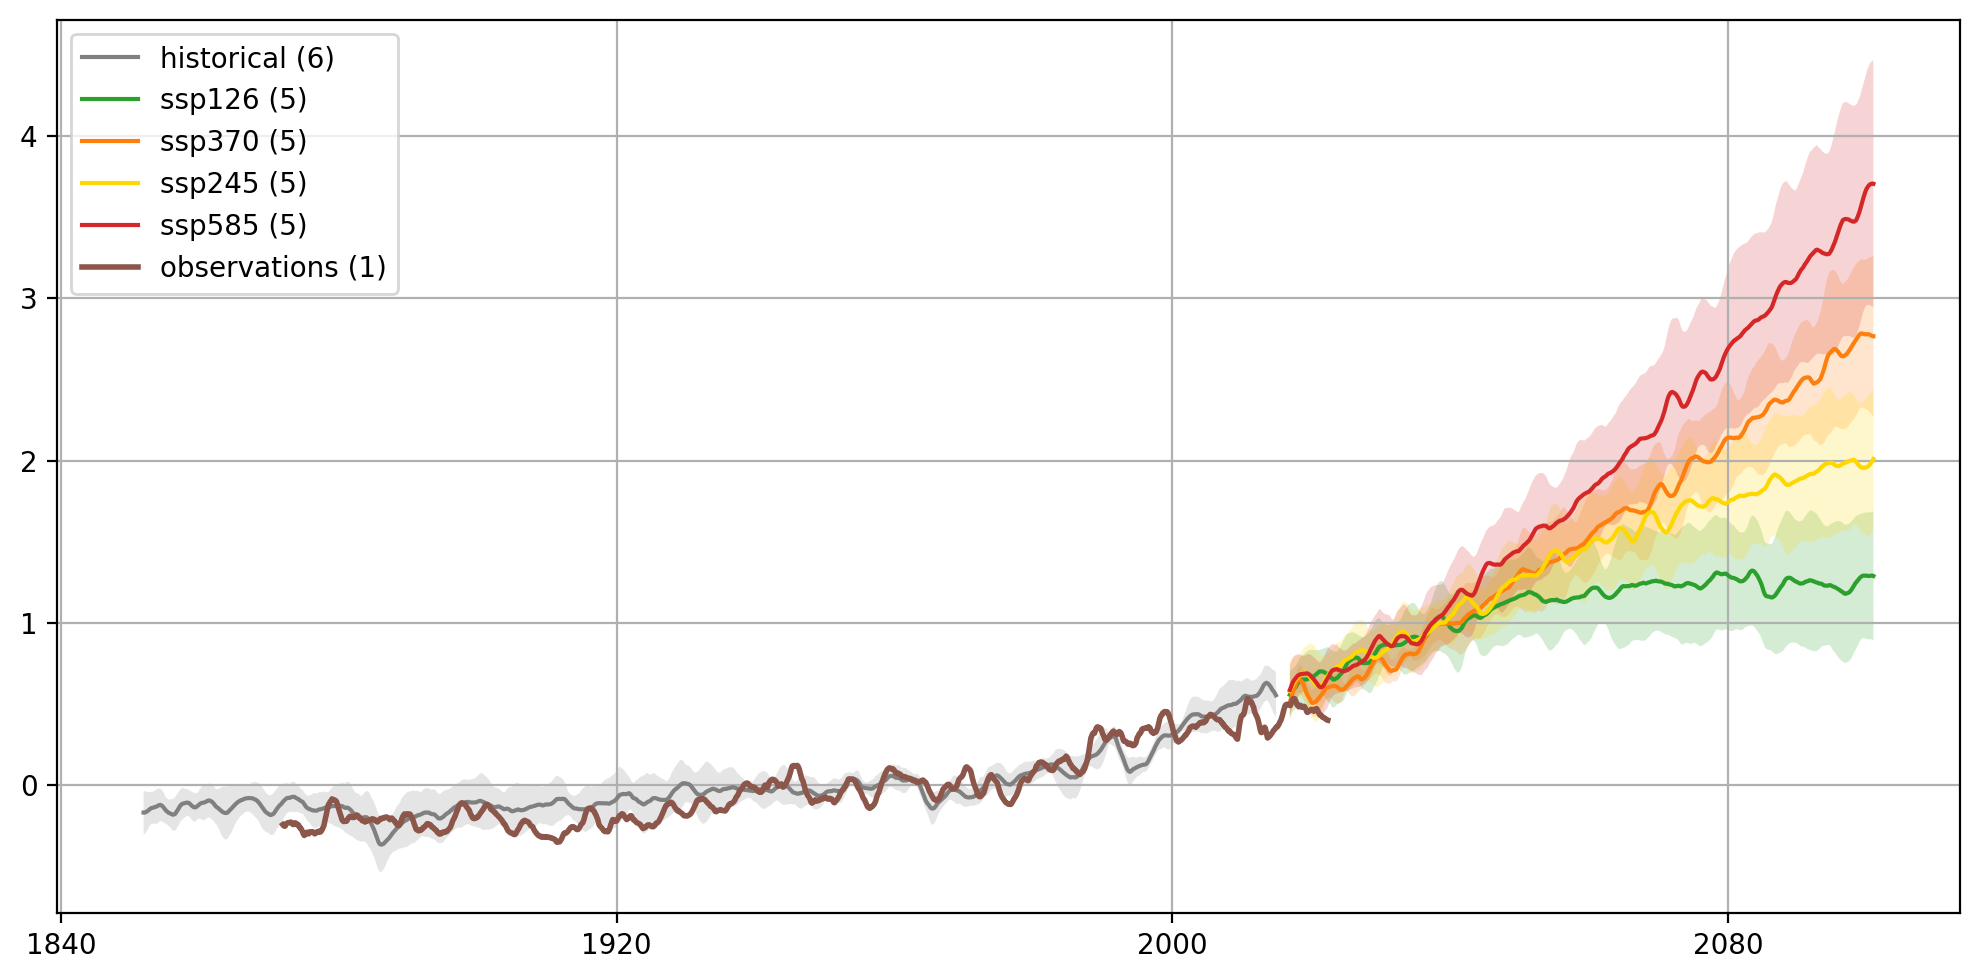

In [21]:
fig, ax = plt.subplots()

color_dict = {
    'historical':'0.5',
    'ssp126': 'C2',
    'ssp245': 'gold',
    'ssp370': 'C1',
    'ssp585': 'C3',
    'observations': 'C5'
}
for experiment, ds in plot_dict.items():
    color = color_dict[experiment]
    smooth = ds['tos'].sel(time=slice(None, '2100')).rolling(time=2*12).mean().squeeze('dcpp_init_year')
    lw = 2 if experiment=='observations' else 1.5
    shaded_line_plot(smooth, 'source_id', ax=ax, spreads=[2.0], alphas=[0.2], line_kwargs=dict(color=color, label=f"{experiment} ({len(ds.source_id)})", lw=lw))
plt.legend(loc=2);
plt.grid()
plt.tight_layout()

In [22]:
toc = time.time()

In [23]:
print(f"Time to spin up cluster: {int(toc_cluster-tic)} seconds")
print(f"Time to run computation: {int(toc-toc_cluster)} seconds")
print(f"Total wall time: {int(toc-tic)} seconds")

Time to spin up cluster: 81 seconds
Time to run computation: 264 seconds
Total wall time: 346 seconds


In [ ]:
client.close()
cluster.close()